In [1]:
import numpy as np
import pandas as pd

In [2]:
def get_timeseries_training_set(data_series: pd.Series, window_size=84, forecast_size=3):
    """ Prepares a dataset for time series forecasting with linear regression """
    y = data_series.to_numpy(dtype=np.float64)

    input_seq = []
    output_seq = []

    for i in range(len(y) - window_size - forecast_size + 1):
        input_seq.append(y[i:i + window_size])
        output_seq.append(y[i + window_size:i + window_size + forecast_size])

    # Convert lists to NumPy arrays
    train_input = np.array(input_seq, dtype=np.float64)  # Shape (n, window_size)
    train_label = np.array(output_seq, dtype=np.float64)  # Shape (n, forecast_size)

    return {
        'train_input': train_input,
        'train_label': train_label
    }

In [3]:
from sklearn.linear_model import LinearRegression

def pretrain_timeseries_models(data_series, window_size=84, forcast_size=3):
    dataset = get_timeseries_training_set(data_series, window_size, forcast_size)
    
    models = [LinearRegression() for _ in range(forcast_size)]
    for i in range(forcast_size):
        models[i].fit(dataset['train_input'], dataset['train_label'][:, i])  # Train separate models for each step

    return models

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def compression_ratio_plot(predicted: np.ndarray, true: np.ndarray, threshold=0.05, plot=True):
    # Ensure predicted and true are numpy arrays
    predicted = np.array(predicted)
    true = np.array(true)
    
    # Compute standard deviation and error threshold
    std_dev = np.std(true)  
    error_threshold = threshold * std_dev  

    # Compute the condition: error exceeds the threshold percentage of std_dev
    condition = np.abs(predicted - true) > error_threshold  
    
    # Compute the compression ratio
    count_satisfying_condition = np.sum(condition)
    total_count = len(true)
    ratio = total_count / count_satisfying_condition if count_satisfying_condition > 0 else np.inf

    if plot:
        plt.figure(figsize=(8, 5))

        # Indices where condition is NOT met (valid points)
        valid_indices = np.where(~condition)[0]
        
        # Plot valid points with thinner lines and markers
        plt.plot(valid_indices, true[valid_indices], 'bo-', markersize=4, linewidth=1, alpha=0.6, label="True (Valid)")
        plt.plot(valid_indices, predicted[valid_indices], 'ro-', markersize=4, linewidth=1, alpha=0.6, label="Predicted (Valid)")

        # Draw thin vertical dashed lines at points where the condition IS met
        for i in np.where(condition)[0]:  
            plt.plot([i, i], [true[i], predicted[i]], 'k--', alpha=0.5, linewidth=1)

        # Labels and formatting
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.title("Predicted vs. True Values (Threshold-Exceeding Points Marked)")
        plt.legend()
        plt.grid(True, linewidth=0.3)

        plt.show()

    return ratio


In [5]:
from tqdm.notebook import tqdm

def fit_predict_plot(data_series:pd.Series, window_size=10, forcast_size=3, verbose=False, train_test_split=0.5):
    data_series = data_series.ffill().bfill()
    train_size = int(len(data_series) * train_test_split)

    # Fit model
    models = pretrain_timeseries_models(data_series.iloc[:train_size], window_size, forcast_size)

    y_pred_list = []

    for idx in range(window_size + train_size, len(data_series) - forcast_size + 1, forcast_size):
        input_window = data_series.iloc[idx - window_size:idx].to_numpy().reshape(1, -1)
        future_prediction = np.array([models[i].predict(input_window)[0] for i in range(forcast_size)])
        y_pred_list.extend(future_prediction)

    # Numpy arrays of true and predicted
    predicted = np.array(y_pred_list)
    true = data_series[window_size + train_size:window_size + train_size + len(predicted)].to_numpy()

    # Output compression ratio
    cr = compression_ratio_plot(predicted, true, plot=verbose)
    print(f"Compression ratio: {cr}")

In [6]:
import numpy as np
from datetime import datetime, timedelta

# Test using a time series dataset
num_rows = 4000
days = np.arange(num_rows)
amplitude = 0.5
baseline_temp = 0.5
num_harmonics = 20
period = 365
random_walk_step = 0.01

start_date = datetime.today()
dates = [(start_date + timedelta(days=int(day))).date() for day in days]

temperature = baseline_temp + amplitude * np.sin(2 * np.pi * days / period)

data_sine = pd.DataFrame({
    'timestamp': dates,
    'temperature': temperature
})

temperature_fourier = baseline_temp

for n in range(1, num_harmonics + 1):
    temperature_fourier += (amplitude / n) * np.sin(2 * np.pi * n * days / period) + (amplitude / n) * np.cos(2 * np.pi * n * days / period)

data_complex_fourier = pd.DataFrame({
    'timestamp': dates,
    'temperature': temperature_fourier
})

temperature_sawtooth = baseline_temp + amplitude * (days % period) / period

data_sawtooth = pd.DataFrame({
    'timestamp': dates,
    'temperature': temperature_sawtooth
})

temperature_random_walk = baseline_temp + np.cumsum(np.random.randn(num_rows) * random_walk_step)

data_random = pd.DataFrame({
    'timestamp': dates,
    'temperature': temperature_random_walk
})

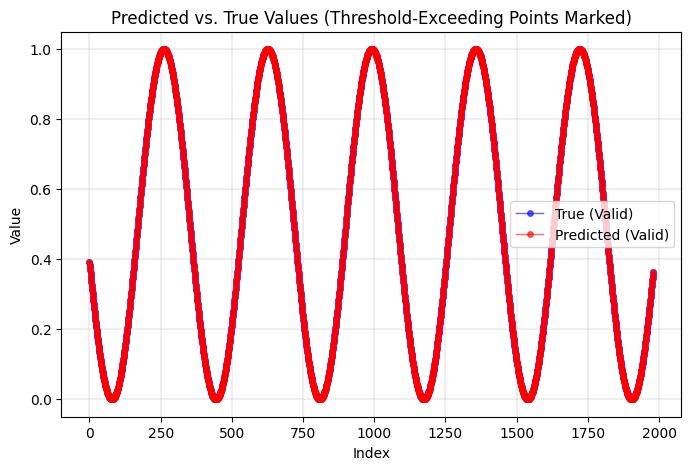

Compression ratio: inf


In [7]:
fit_predict_plot(data_sine['temperature'], window_size=20, forcast_size=3, verbose=True)

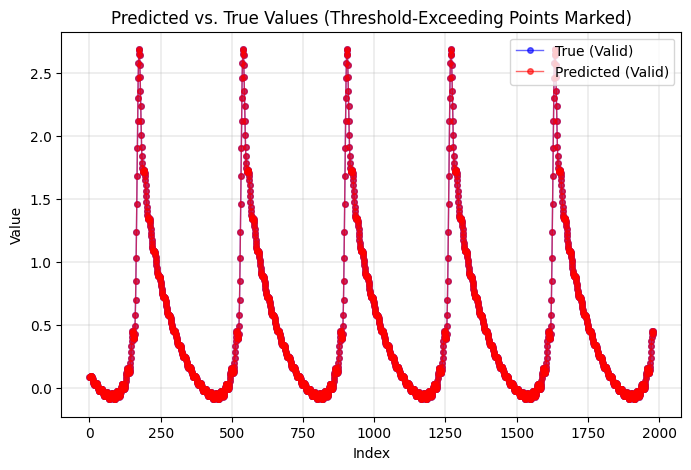

Compression ratio: inf


In [8]:
fit_predict_plot(data_complex_fourier['temperature'], window_size=20, forcast_size=3, verbose=True)

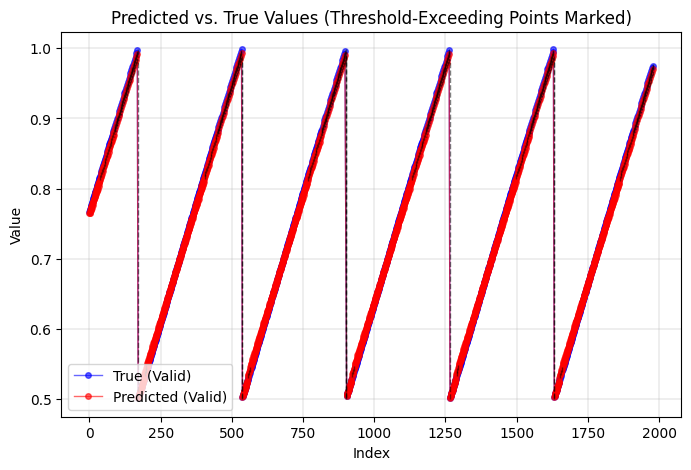

Compression ratio: 4.419642857142857


In [9]:
fit_predict_plot(data_sawtooth['temperature'], window_size=20, forcast_size=3, verbose=True)

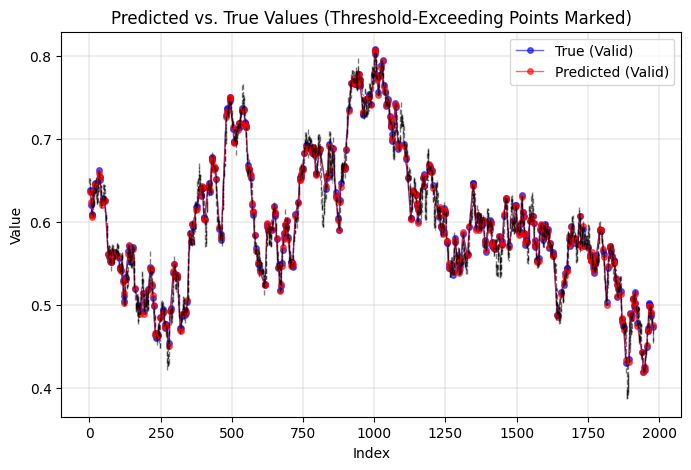

Compression ratio: 1.2992125984251968


In [10]:
fit_predict_plot(data_random['temperature'], window_size=20, forcast_size=3, verbose=True)

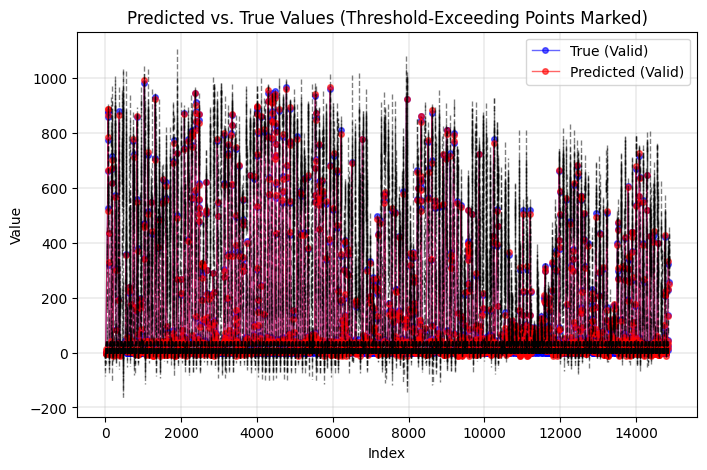

Compression ratio: 1.1389612379347327


In [11]:
csv_path = "ariviyalNagar.csv"
column_1 = "Port 1"

data_df = pd.read_csv(csv_path)

fit_predict_plot(data_df[column_1], 20, 3, True)

c:\Users\atlee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


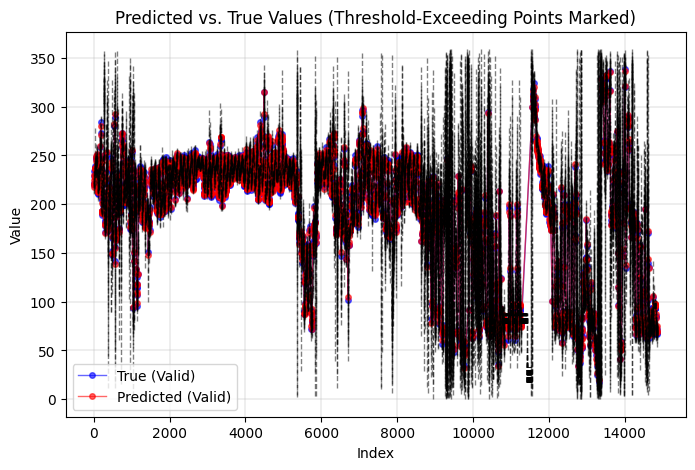

Compression ratio: 1.2818346409173205


In [12]:
column_2 = "Port 1.4"
fit_predict_plot(data_df[column_2], 20, 3, True)

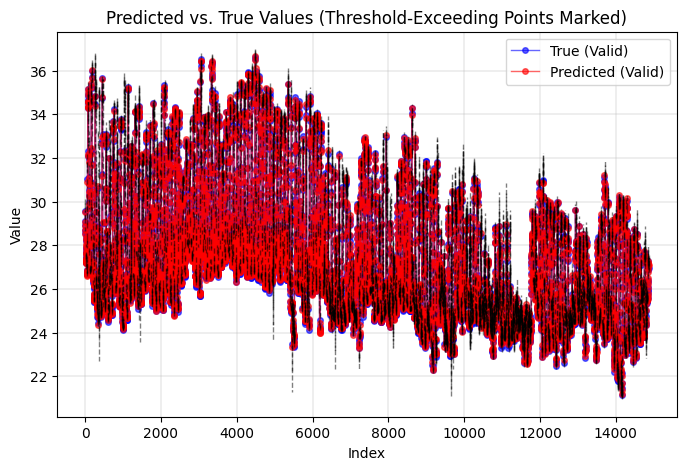

Compression ratio: 1.7528884697005422


In [13]:
column_3 = "Port 1.7"
fit_predict_plot(data_df[column_3], 20, 3, True)

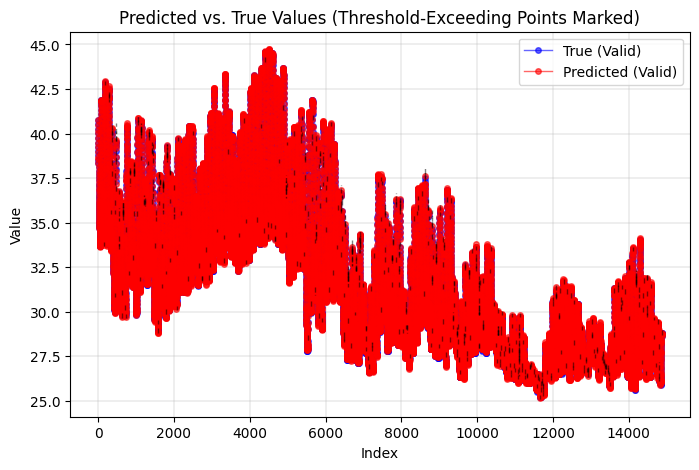

Compression ratio: 26.08421052631579


In [14]:
column_4 = "Port 2.1"
fit_predict_plot(data_df[column_4], 20, 3, True)

In [15]:
from tqdm.notebook import tqdm

def fit_predict_plot_sync_all(data_series:pd.Series, window_size=10, forcast_size=3, verbose=False, train_test_split=0.5):
    data_series = data_series.ffill().bfill()
    train_size = int(len(data_series) * train_test_split)

    # Fit model
    models = pretrain_timeseries_models(data_series.iloc[:train_size], window_size, forcast_size)

    y_pred_list = []

    for idx in range(window_size + train_size, len(data_series) - forcast_size + 1, forcast_size):
        original_window = data_series.iloc[idx - window_size:idx].to_numpy()

        # Fit a line y = mx + c
        x = np.arange(len(original_window)).reshape(-1, 1)
        y = original_window.reshape(-1, 1)
        reg = LinearRegression().fit(x, y)
        m, c = reg.coef_[0, 0], reg.intercept_[0]

        # Generate a new sliding window using the fitted line
        input_window = np.array([m * x_i + c for x_i in range(window_size)], dtype=float)

        future_prediction = np.array([models[i].predict(input_window.reshape(1, -1))[0] for i in range(forcast_size)])
        y_pred_list.extend(future_prediction)

    # Numpy arrays of true and predicted
    predicted = np.array(y_pred_list)
    true = data_series[window_size + train_size:window_size + train_size + len(predicted)].to_numpy()

    # Output compression ratio
    cr = compression_ratio_plot(predicted, true, plot=verbose)
    print(f"Compression ratio: {cr}")

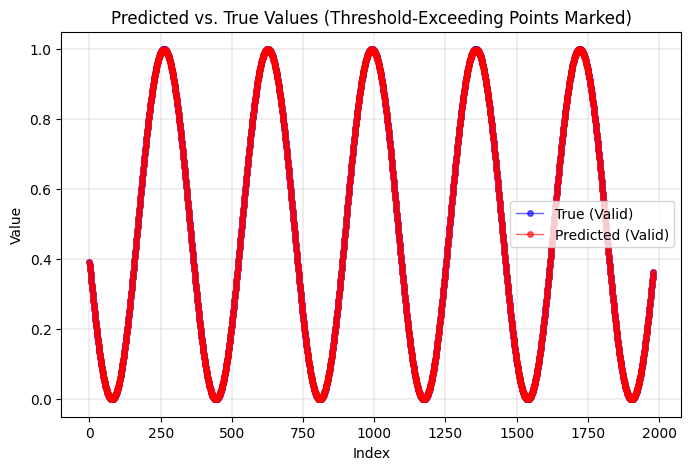

Compression ratio: inf


In [16]:
fit_predict_plot_sync_all(data_sine['temperature'], window_size=20, forcast_size=3, verbose=True)

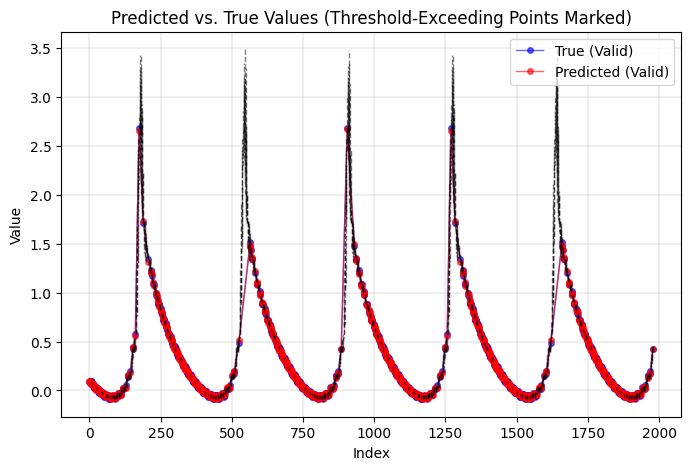

Compression ratio: 2.268041237113402


In [17]:
fit_predict_plot_sync_all(data_complex_fourier['temperature'], window_size=20, forcast_size=3, verbose=True)

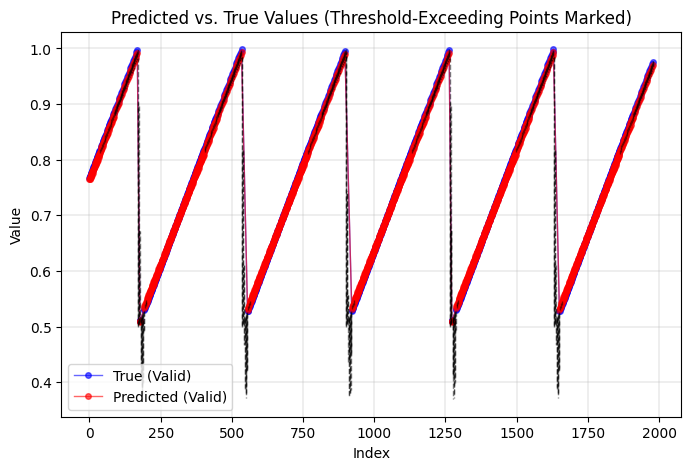

Compression ratio: 3.680297397769517


In [18]:
fit_predict_plot_sync_all(data_sawtooth['temperature'], window_size=20, forcast_size=3, verbose=True)

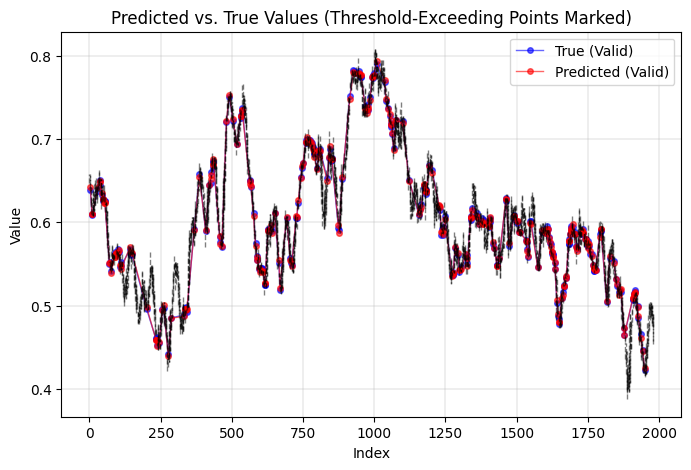

Compression ratio: 1.1813842482100239


In [19]:
fit_predict_plot_sync_all(data_random['temperature'], window_size=20, forcast_size=3, verbose=True)

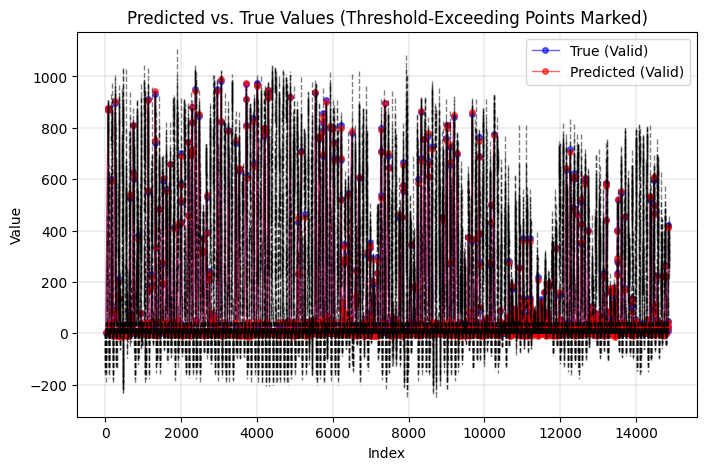

Compression ratio: 1.0898695205981528


In [20]:
csv_path = "ariviyalNagar.csv"
column_1 = "Port 1"

data_df = pd.read_csv(csv_path)

fit_predict_plot_sync_all(data_df[column_1], 20, 3, True)

c:\Users\atlee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


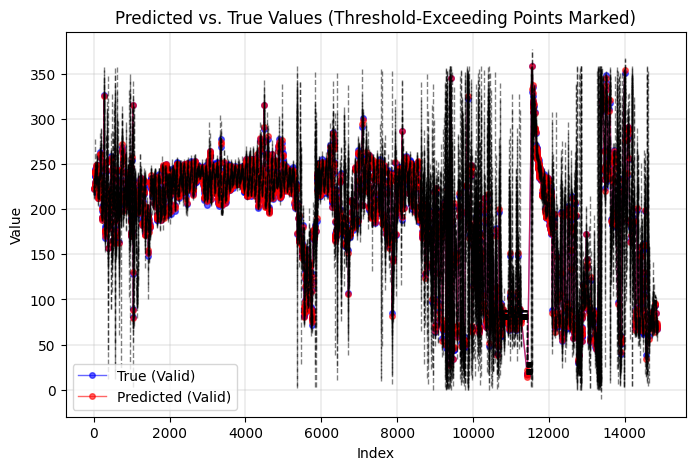

Compression ratio: 1.2431438127090302


In [21]:
column_2 = "Port 1.4"
fit_predict_plot_sync_all(data_df[column_2], 20, 3, True)

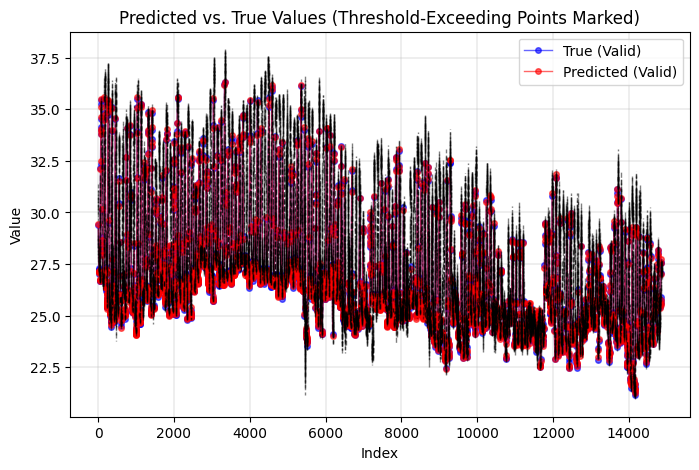

Compression ratio: 1.2822768434670115


In [22]:
column_3 = "Port 1.7"
fit_predict_plot_sync_all(data_df[column_3], 20, 3, True)

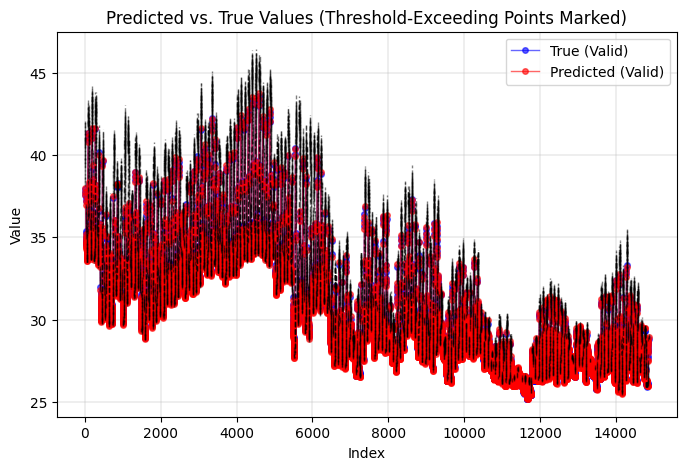

Compression ratio: 1.9440376569037656


In [23]:
column_4 = "Port 2.1"
fit_predict_plot_sync_all(data_df[column_4], 20, 3, True)